In [27]:
import time
tic = time.time()
import numpy as np
from numpy import random
import pandas as pd
from sklearn.neighbors import DistanceMetric
import functools
import operator
import matplotlib.pyplot as plt
import random
from scipy.spatial import distance
from sklearn.metrics import davies_bouldin_score
import seaborn as sns
import math
from sklearn.neighbors import DistanceMetric
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Answers

**Group members:**

- Elio Abikaram
- Marc Agustí
- Patrick Altmeyer
- Simon Neumeyer

## Code

#### Minimum spanning tree

To use Kruskal's algorithm to find the minimum spanning tree we need to first compute distances of all $\frac{N(N-1)}{2}$ possible edges that connect the $n$ vertices. To compute the distances we rely on the Euclidean distance

$$
d(x,y) = \sqrt{(x_1-y_1)^2 + (x_2-y_2)^2 + ... + (x_N-y_N)^2}
$$

which in Python can be implemented as follows:

In [28]:
def compute_dist(df):
    size = len(df)
    result = []
    arr = df.values
    for i in range(size):
        for j in range(i+1,size):
            # We use the package "distance" to compute the euclidean distance between
            # the different points in the dataset
            result.append([i, j, math.sqrt(sum((arr[i] - arr[j])**2))])

    ordered_result = sorted(result, key=lambda t: t[::-1])
    return ordered_result

The function also stores the corresponding edges and sorts them in terms of non-decreasing order of distances.

We propose the following function to compute clusters through MST clustering. It takes as inputs the number of clusters $K$, the number of vertices $N$ and the ordered list of edges we just computed above. The code is commmented, but let us lay out the high-level methodology upfront. To find the minimum spanning tree it makes sense to differentiate the following cases:

- case 1: None of them are in a cluster:
- case 2: Only one of them is already in a cluster:
- case 3: Both of them are already in a cluster:
    - 3a: Both of them are in the same cluster: do nothing
    - 3b: They are in different clusters: merge the 2 corresponding clusters


In [29]:
def MST_Clustering(K, N, ordered_result):
    counter = 0
    cluster_dict = {-1:[]}
    vertex = []
    Cluster_Matrix= pd.DataFrame({"vertex":range(N), "cluster":-1})
    final_number_clusters = N-K
    for ite in ordered_result:
        # The keys for both vertices in the current edge (ite) whether they have been allocated to a 
        # cluster or not. If they haven't been allocated they are assigned -1, otherwise the cluster.
        key_0 = Cluster_Matrix.loc[ite[0], 'cluster']
        key_1 = Cluster_Matrix.loc[ite[1], 'cluster']
        if (key_0 == key_1) and (key_0 != -1):
            pass
        else:
            counter += 1
            # This corresponds to case 1 (see above):
            if (key_0 == -1) and (key_1 == -1):
                Cluster_Matrix.loc[ite[0], 'cluster'] = max(Cluster_Matrix.cluster) +1
                Cluster_Matrix.loc[ite[1], 'cluster'] = max(Cluster_Matrix.cluster)
                cluster_dict[max(cluster_dict) +1] = [ite[0]]
                cluster_dict[max(cluster_dict)] += [ite[1]]
                vertex.append(ite[0])
                vertex.append(ite[1])
            # This corresponds to case 2 (see above):
            elif (key_0 == -1) or (key_1 == -1):
                if key_0 == -1:
                    Cluster_Matrix.loc[ite[0], 'cluster'] = key_1
                    cluster_dict[key_1] += [ite[0]]
                    vertex.append(ite[0])
                else:
                    Cluster_Matrix.loc[ite[1], 'cluster'] = key_0
                    cluster_dict[key_0] += [ite[1]]
                    vertex.append(ite[1])
            # This corresponds to case 3 (see above):
            else:
                Cluster_Matrix.loc[Cluster_Matrix['cluster'] == key_1, 'cluster'] = key_0
                cluster_dict[key_0] += cluster_dict[key_1]
                del cluster_dict[key_1]
        if counter == final_number_clusters:
            for i in range(N):
                if Cluster_Matrix.loc[i, 'cluster'] == -1:
                    Cluster_Matrix.loc[i, 'cluster'] = max(Cluster_Matrix.cluster) +1
                    cluster_dict[max(cluster_dict) +1] = [i]
                    vertex.append(i)
            del cluster_dict[-1]
            return cluster_dict, Cluster_Matrix.cluster

Just a helpfer function serialize the output:

In [30]:
def get_df(cluster_dict):
    ind_list = []
    clust_list = []

    for k, v in cluster_dict.items():
        [clust_list.append(k) for i in v]
        [ind_list.append(val) for val in v]

    df_s = pd.DataFrame()
    df_s['index'] = ind_list
    df_s['Cluster'] = clust_list
    
    df_s = df_s.sort_values('index').set_index('index')
    return df_s

#### K-means clustering

The implementation of K-means in Python can be found below. Let us briefly outline the high-level details of the algorithm here. The basic idea is as follows:

1. Randomly draw K observations from the data to be used as the intial centroids $C^{(0)}_{k}$ of the K clusters.
2. Compute some meaure of distance (we choose Euclidean norm) between data point $x_{i,-K}$ and all centroids $C_{k}^{(0)}$ and assign $x_{i,-K}$ to its nearest centroid. Procede like this for all $i$. 
3. Compute new centroids $C_{k}^{(1)}$ as the means of all points allocated to cluster $k$. 

Repeat steps (2) and (3) until convergence: $C_{k}^{(t-1)}-C_{k}^{(t)}=0$



In [31]:
# Randomly assign indeces of cluster centroids:
def initiate_centroids(k, df):
    centroids = []
    random.seed(10) #for reproducability  
    #generate random centroid indeces
    initial_index_centroid = random.sample(range(0, len(df)), k)
    #find the data points corresponding the the indeces:
    for i in initial_index_centroid:
        centroids.append(df.loc[i])
    return np.array(centroids)

# To find the closest centroid to each data point:
def findClosestCentroids(centroids, df):
    assigned_centroid = []
    arr = df.to_numpy()
    #iterate over every data point in the dataframe:
    for row in arr:
        distance=[]
        #find distance of data point with each cluster:
        for center in centroids:          
            distance.append(np.linalg.norm(row-center))     
        #assign data point to closest cluster:
        assigned_centroid.append(np.argmin(distance))
    return assigned_centroid


#To update the centroid of the clusters:
def calc_centroids(clusters, df): 
    #initiate empty list for new centroids of each cluster:
    new_centroids = []
    #df including each point and its respective cluster 
    arr = np.c_[df.to_numpy(), clusters]
    #iterate over the distinct clusters
    for c in np.unique(clusters):    
        #take out the data points corresponding to each cluster:
        current_arr = arr[arr[:, -1] == c][:,:-1]   
        #find the new cluster centroid which is the mean of the clusters we already assigned
        cluster_mean = current_arr.mean(axis=0)                                          
        #append the new centroid
        new_centroids.append(cluster_mean)   
    return np.vstack(new_centroids)

#Recursively find and update cluster centroids:
#n: number of clusters, df: dataframe of data points

In [32]:
def KMeans_Clustering(k, df):
    #initiate centroids:
    old_centroids = initiate_centroids(k, df)
    #initiate new centroids (do this for first while loop condition to work)
    new_centroids = calc_centroids(findClosestCentroids(old_centroids, df), df)
    # Iterate until the absoulte difference between the coordinates of all centroids 
    #does not change, ie: the k-means algorithm converges:
    centroids = [old_centroids, new_centroids]
    i = 0
    while np.any(np.absolute(np.array(new_centroids) - np.array(old_centroids)) > 0):
        #set new centroids as the old ones:
        i += 1
        old_centroids = new_centroids
        #find the new ones:
        new_centroids = calc_centroids(findClosestCentroids(old_centroids, df), df)
        centroids += [new_centroids]
        #print(np.array(new_centroids))
    return findClosestCentroids(new_centroids, df), centroids

We use a small helper function to turn the K-means output into a more convenient format:

In [33]:
def centroids_to_df(cent):
    df = pd.DataFrame(cent[0])
    k = np.shape(cent)[1]
    df['k'] = range(k)
    df['iter'] = 0
    for i in range(1,np.shape(cent)[0]):
        df_new = pd.DataFrame(cent[i])
        df_new['k'] = range(k)
        df_new['iter'] = i 
        df = pd.concat([df, df_new], axis=0)
    return df

And another small helper to serialize the results:

In [34]:
def get_dictionary(df):
    my_dict = df.iloc[:,0].to_dict()
    list_of_tup = [(v,k) for k,v in my_dict.items()]
    my_dict = {}
    for i in range(len(list_of_tup)):
        k = list_of_tup[i][0]
        v = list_of_tup[i][1]
        if k not in my_dict.keys():
            my_dict[k] = [v]
        else:
            my_dict[k] += [v]
    my_dict
    return my_dict

## Benchmarking

To run the benchmark we first code up the two indices to assess clustering output.

### Davies Bouldin algorithm

The Davies Bouldin algorithm defined as 

$$
DB = \frac{1}{K} \sum_{i=1}^K D_i
$$

can be coded up in Python as follows:

In [35]:
def Davies_Bouldin(cluster_dict, df):
    
    # We compute the index of the clusters 
    
    clusters = []
    for n in cluster_dict:
        clusters.append(n)
        
    # We compute the coordinates of the centroid for each cluster
    
    centroid_dict = {}
    for n in clusters:
        mask = (df.Cluster == n)
        cluster_df = df[mask]
        centroid = cluster_df.mean()
        centroid = centroid.to_list()
        list_ = []
        for el in range(0,len(list(df.columns[:-1]))):
            list_.append(centroid[el])
            centroid_dict[n] = list_
            
    # We compute the measure of the scatter within the cluster, S_i

    S_i = {}
    for n in cluster_dict:
        sum_ = 0
        for el in cluster_dict[n]:
            sum_ += distance.euclidean(df.iloc[el][:-1],centroid_dict[n])
            average = sum_/len(cluster_dict[n])
            S_i[n] = average
            
    # Compute the distance between the clusters, i.e., the distance between the centroids of the clusters
    
    M_ij = {}
    centroids = list(centroid_dict.keys())
    for i in range(0,len(centroids)):
        for j in range(i+1,len(centroids)):
            d = distance.euclidean(centroid_dict[centroids[i]],centroid_dict[centroids[j]])
            M_ij[(centroids[i],centroids[j])] = d
    
    # We compute D_i by computig in a forloop R_ij
    
    dispersion = list(S_i.keys())
    D_i = {}
    for i in range(0, len(dispersion)):
        D_i[dispersion[i]] = 0
        for j in range(0,len(dispersion)):
            if i!=j:
                try:
                    R_ij = (S_i[dispersion[i]]+S_i[dispersion[j]])/(M_ij[(dispersion[i],dispersion[j])])
                    if R_ij >= D_i[dispersion[i]]:
                        D_i[dispersion[i]] = R_ij
                except:
                    R_ij = (S_i[dispersion[i]]+S_i[dispersion[j]])/(M_ij[(dispersion[j],dispersion[i])])
                    if R_ij >= D_i[dispersion[i]]:
                        D_i[dispersion[i]] = R_ij
                        
    count = 0
    for n in D_i:
        count += D_i[n]
    DB = count/len(D_i)
    return DB

### The Dunn Index

The Dunn index defined as 

$$
DU = \frac{\min_{i\ne j} \delta (C_i,C_j)}{\max_i \Delta_i}
$$

which can be coded up in Python as follows:

In [36]:
def max_within(ordered_result, cluster_dict):
    for i in range(len(ordered_result)):
        for k,v in cluster_dict.items():
            if ordered_result[-i-1][0] in v and ordered_result[-i-1][1] in v:
                return ordered_result[-i-1][2]

def min_between(ordered_result, cluster_dict):
    for i in range(len(ordered_result)):
        for k,v in cluster_dict.items():
            if ordered_result[i][0] in v and ordered_result[i][1] not in v:
                return ordered_result[i][2]

def dunn(ordered_result, cluster_dict):
    den = max_within(ordered_result, cluster_dict)
    num = min_between(ordered_result, cluster_dict)
    return num/den

We summarize the benchmark process in a small wrapper function which takes as inputs the number of clusters $K$ and the data matrix. It returns the two benchmark indices introduced above.

In [37]:
def benchmark(K, df, method):
    df = df.copy()
    if method == "kmeans":
        labels, cent = KMeans_Clustering(K, df)
        df = pd.concat([pd.Series(labels), df], axis=1)
        df.columns = ["Cluster"] +  list(df.columns)[1:]
        cluster_dict = get_dictionary(df)
    else:
        cluster_dict, col_clust = MST_Clustering(K, N, ordered_result)
        df['Cluster']= get_df(cluster_dict)['Cluster']
    
    DB_MST = Davies_Bouldin(cluster_dict,df)
    Dunn_MST = dunn(ordered_result, cluster_dict)
   
    return DB_MST, Dunn_MST

#### Thyroid data

The thyroid data is small $N$ and (relatively) higher $p$ (dimension). Here we will use the wrapper function intorduced above to investigate how the custering performance varies as we change the number of clusters $K$. The provided text data was preprocessed and saved as `.csv` files. We first import the data:

In [38]:
df_thyroid = pd.read_csv('thyroid_clean.csv')
N = len(df_thyroid)

We then compute the distances of all possible edges.

In [39]:
%%time
ordered_result = compute_dist(df_thyroid)

CPU times: user 10.7 s, sys: 677 ms, total: 11.4 s
Wall time: 18.3 s


Finally, for $K$ ranging from 2 to $N$ at regular intervals of 10 we perform the two clustering methods. Since low values of the DB index and high value sof the Dunn index both indicate good clustering outcomes, we expect the two measures to be negatively correlated. We also expect that the clustering performance will reach its "optimum" as $K \rightarrow N$. But of course in practice clustering is done with the goal to register the data in a lower-d space defined by $K$ latent clusters. Simply declaring each point as its own clusters defeats that purpose, even though the two indeces would attribute great clustering accuracy to that approach.

##### 1.) MST clustering

In [40]:
%%time
n_clusters = []
DB_MST = []
Dunn_MST = []
for K in range(2, N+1, 10):
    n_clusters.append(K)
    DB, Dunn = benchmark(K, df_thyroid, method="mst")
    DB_MST.append(DB)
    Dunn_MST.append(Dunn)

CPU times: user 31.5 s, sys: 254 ms, total: 31.8 s
Wall time: 39.1 s


The two plots below show how the DB and Dunn index vary with $K$, respectively. As expectted the DB index utlimately declines with $K$, while the Dunn index ultimately increases in $K$. Interestingly though, these general trends are not monotonistic: there are occasion where $DB(K_1)<DB(K_2)$ or similary $Dunn(K_1)>Dunn(K_2)$ for $K_1<K_2$. In those cases it seems reasonable to choose $K_1$ over $K_2$ even though there will be some $K_3>>K_2>K_1$ for which $DB(K_3)<DB(K_1)$ and $Dunn(K_3)>Dunn(K_1)$. For example, based on the DB index below we would definitely prefer $K=50$ over $K=100$. For the sake of reducing dimensionality we may also prefer $K=50$ to all $K>100$ that at the face of it lead to better clustering performance.

/Users/patrickaltmeyer/.pyenv/versions/3.8.0/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


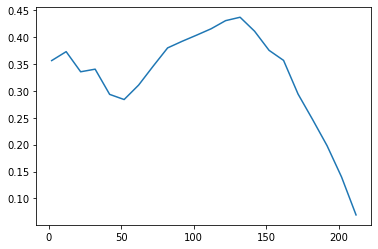

/Users/patrickaltmeyer/.pyenv/versions/3.8.0/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


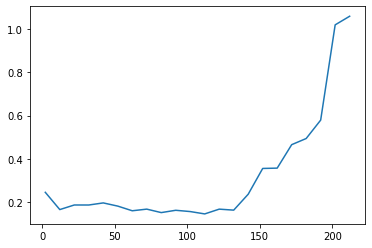

In [41]:
import seaborn as sns
sns.lineplot(n_clusters,DB_MST)
plt.show()
sns.lineplot(n_clusters,Dunn_MST)
plt.show()

##### 2.) K-means clustering

In [42]:
%%time
n_clusters = []
DB_km = []
Dunn_km = []
for K in range(2, N+1, 10):
    n_clusters.append(K)
    DB, Dunn = benchmark(K, df_thyroid, method="kmeans")
    DB_km.append(DB)
    Dunn_km.append(Dunn)

CPU times: user 1min 32s, sys: 732 ms, total: 1min 33s
Wall time: 1min 55s


Once again the two plots below show how the DB and Dunn index vary with $K$, respectively, and we observe the same broad pattern. Curiously here $K=2$ looks like a good choice considering how much the dimensionality would be reduced. Again this choice is not necessarily optimal and depends on the cost tradeoff between high dimensionality and low clustering accuracy. Depending on what is valued more for a particular use case one would choose low $K$ to reduce dimensionality and high $K$ if missclassifcations are very costly.

/Users/patrickaltmeyer/.pyenv/versions/3.8.0/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


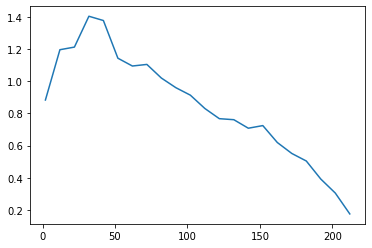

/Users/patrickaltmeyer/.pyenv/versions/3.8.0/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


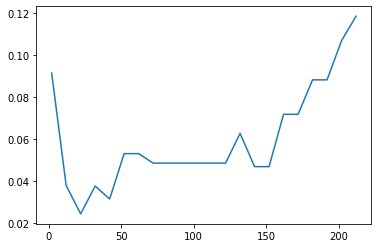

In [43]:
import seaborn as sns
sns.lineplot(n_clusters,DB_km)
plt.show()
sns.lineplot(n_clusters,Dunn_km)
plt.show()

#### Synthetic data

The synthetic is higher $N$ and 2-dimensional, so clusters can be easily visualized. Here we are therefore interested in seeing how well the two methods group observations into $K=15$ clusters. 

In [53]:
df= pd.read_csv('synthetic_clean.csv')
N = len(df)
k = 15

Once again we run the two different clustering algorithms.

In [54]:
ordered_result = compute_dist(df)

##### 1.) MST clustering

The clusters identified by MST are differentiated by colour in the chart below. Evidently MST overall does a good job at grouping similar observations together. Note also that some clusters consist of only one individual observation (when and why this happens was already discussed above). 

In [58]:
%%time
cluster_dict, cluster_col  = MST_Clustering(k, len(df), ordered_result)
df_labelled = get_df(cluster_dict)
df_labelled = pd.concat([df_labelled, df], axis=1)

CPU times: user 21.1 s, sys: 240 ms, total: 21.4 s
Wall time: 22.1 s


In [59]:
%%R -i df_labelled
library(ggplot2)
library(gganimate)
library(data.table)
library(ggiraph)
dt <- data.table(df_labelled)
setnames(dt, c("Cluster", "V1", "V2"), c("label", "x", "y"))

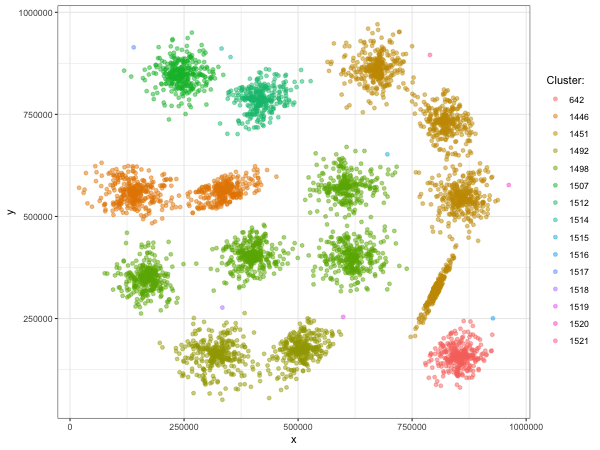

In [60]:
%%R -w 600 -h 450
p <- ggplot() +
    geom_point(data=dt, aes(x=x, y=y, colour=factor(label)), alpha=0.5) +
    scale_colour_discrete(
        name="Cluster:"
    ) +
    theme_bw()
p

##### 2.) K-means

Finally, below we repeat the same exercise for K-means. Here we have also animated the path of the estimated centroids. K-means overall produces clusters that are more evenly sized than MST. In some cases clusters that looks like they should correspond to just one single cluster are in fact classified as two separate clusters. Similarly, some clusters that upon visual inspection look distinct are grouped together. The animation is interesting in that it illustrates the fact that the algorithm works harder and longer for cases where it fails to produce adequate clusters. For example, the estimated light blue and orange clusters should arguably be classified as one single cluster. Consequently convergence in these cases is only reached after many iterations: since all points in the blue-orange cluster are close to each other, estimated centroids change ever so slightly even after many iterations as observations jump from the orange to the blue cluster and vice versa. So this animation nicely illustrates one of the shortfalls of K-means. The R code that produces the animation can be found below.

![Animation](output/anim.gif "segment")

In [55]:
%%time
labels, cent = KMeans_Clustering(k, df)

CPU times: user 56 s, sys: 662 ms, total: 56.6 s
Wall time: 1min 15s


In [57]:
cent_df = centroids_to_df(cent)
df_labelled = pd.concat([pd.Series(labels), df], axis=1)
df_labelled.columns = ["Cluster", "x", "y"]
cent_df.to_csv("output/cent_df.csv")
df_labelled.to_csv("output/df_labelled.csv")

In [51]:
%%R -i cent_df -i df_labelled
library(ggplot2)
library(data.table)
library(ggiraph)
cent_dt <- data.table(cent_df)
setnames(cent_dt, c("0","1", "iter"), c("x", "y", "iteration"))
dt <- data.table(df_labelled)
setnames(dt, c("Cluster"), c("label"))

p <- ggplot() +
    geom_point(data=dt, aes(x=x, y=y, colour=factor(label)), alpha=0.5) +
    geom_point(
        data=cent_dt,
        aes(x=x,y=y,fill=factor(k)),
        colour="black",
        size=3,
        shape=24
    ) +
    transition_states(
        states = cent_dt$iter,
        transition_length = 2,
        state_length = 1
    ) +
    scale_fill_discrete(guide=F) +
    scale_colour_discrete(
        name="Cluster:"
    ) +
    theme_bw() +
    enter_fade() +
    ease_aes('sine-in-out') +
    shadow_trail(distance = 0.05)

anim_save("output/anim.gif",p, width = 600, height = 600)